# Diagnosing Myocardial Infarction using Long-Short Term Memory networks (LSTM’s)

## Long-Short Term Memory

Pertama-tama, apa itu jaringan Memori Jangka Pendek (LSTM)? Jawaban singkatnya adalah: itu adalah jaringan khusus yang mampu "mengingat" input sebelumnya. Setiap neuron, atau simpul LSTM, dalam jaringan seperti itu mempertahankan keadaan internal, berdasarkan input sebelumnya. Ini menggunakan kondisi saat ini untuk membuat prediksi tentang data input baru. Selama pelatihan ia mempelajari apa yang harus diingat dan apa yang harus dilupakan untuk membuat prediksi yang tepat. Properti ini adalah mengapa LSTM sangat cocok untuk tugas-tugas klasifikasi mengenai data deret waktu seperti pemrosesan bahasa alami atau ... klasifikasi sinyal EKG!

Jika Anda lebih tertarik pada jawaban panjang dan ingin tahu lebih banyak tentang cara kerja LSTM, saya sangat menyarankan Anda membaca blog Colah tentang topik ini sebagai tempat ia menjelaskan topik dengan ahli.

## PhysioNet and the PTB Diagnostic ECG Database

PhysioNet hosts several large data sets of physiological signals and released a related open-source software package, the PhysioToolkit, which contains many useful packages to allow for easy processing of their data sets. One of the data sets is the PTB Diagnostic ECG database. It contains ECG records of 290 subjects, of which 52 are healthy controls, 148 have had a Myocardial infarction (more commonly known as a heart attack). The remaining 90 subjects suffer from a different heart disease. For the sake of this example we will only use the recordings of the patients with Myocardial infarction and the healthy controls.

### Preparation

Kami akan menggunakan implementasi python dari Paket Perangkat Lunak WaveForm DataBase (wfdb) dari PhysioToolkit untuk mengunduh data dari Physiobank dan berinteraksi dengannya. Anda dapat menginstalnya melalui pip:

In [1]:
pip install wfdb

     |████████████████████████████████| 102kB 3.3MB/s 
     |████████████████████████████████| 163kB 8.6MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=7a97cf155363adfcce021c4e9b87d79c40180214f2e45a88f420e4e1849e4c76
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


Selain wfdb kita juga akan menggunakan Tensorflow, keras, numpy, panda, sklearn, dan matplotlib. Karena paket-paket ini cukup standar di bidang pembelajaran mesin, saya berasumsi Anda telah menginstalnya dan tidak akan menginstalnya.

Sebelum kita mulai coding, impor terlebih dahulu semua paket yang digunakan:

In [2]:
from wfdb import io, plot
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


### Getting the data

Paket wfdb mendukung pengunduhan basis data PhysioNet. Pertama, dapatkan daftar catatan yang tersedia untuk diunduh dari database ptdb dan kemudian unduh file-file itu. Setelah unduhan (ini membutuhkan beberapa menit), mari kita muat catatan pertama dan lihat data apa yang dikandungnya.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_sinyal = ('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0')

In [0]:
# First get the list of available records and then download 
# those records and store them in data_folder.
record_names = io.get_record_list('ptbdb')
#io.dl_database('ptbdb', data_folder, record_names) // untuk download data ke folder

In [0]:
# Read the first record
record_name = record_names[0]
record = io.rdrecord(record_name=os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', record_name)) 

Catatan berisi beberapa atribut. Yang akan kita gunakan adalah:

     record.p_signal: Sensor mentah nilai dari ECG. Ini adalah larik sig_len oleh n_channels. Panjang sinyal (jumlah sampel) per rekaman dapat berbeda, tetapi jumlah saluran selalu 15
     record.sig_name: nama setiap saluran
     record.sig_len: panjang atau jumlah sampel rekaman
     record.comments: Daftar string yang berisi informasi tambahan tentang subjek. Ini juga termasuk alasan penerimaan (item kelima) yang akan kita gunakan sebagai label

Mari kita mendapatkan semua atribut ini sebagai metadata dan memuatnya ke dalam kerangka data panda untuk penanganan yang mudah. Kami belum memuat data sinyal mentah untuk menghemat memori.

In [7]:
from tqdm import tqdm
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', record_name))
    label = record.comments[4].split(": ")[-1]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})
    
channels = record.sig_name
df_records = pd.DataFrame(records)  

100%|██████████| 549/549 [14:10<00:00,  1.83s/it]


In [8]:
print (df_records)

                    name                  label     patient  signal_length
0    patient001/s0010_re  Myocardial infarction  patient001          38400
1    patient001/s0014lre  Myocardial infarction  patient001         115200
2    patient001/s0016lre  Myocardial infarction  patient001         115200
3    patient002/s0015lre  Myocardial infarction  patient002         115200
4    patient003/s0017lre  Myocardial infarction  patient003         115200
..                   ...                    ...         ...            ...
544  patient292/s0555_re  Myocardial infarction  patient292         120012
545  patient292/s0556_re  Myocardial infarction  patient292         120012
546  patient293/s0557_re  Myocardial infarction  patient293         120012
547  patient293/s0558_re  Myocardial infarction  patient293         120012
548  patient294/s0559_re  Myocardial infarction  patient294         120012

[549 rows x 4 columns]


### Data exploration: Comparing the data

Kami sekarang siap untuk mulai melakukan beberapa ilmu data! Pertama-tama mari kita bandingkan EKG pasien kontrol dan infark yang sehat:


In [0]:
# Get the first occurence of healthy control and Myocardial infarction
control = df_records[df_records['label'] == 'Healthy control'].iloc[0]
infarct = df_records[df_records['label'] == 'Myocardial infarction'].iloc[0]
#kardio  = df_records[df_records['label'] == 'Cardiomyopathy'].iloc[0]
#bundle  = df_records[df_records['label'] == 'Bundle branch block'].iloc[0]
#disritmia = df_records[df_records['label'] == 'Dysrhythmia'].iloc[0]

In [0]:
# Get the signal data
control_data = io.rdrecord(record_name=os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', control['name'])).p_signal
infarct_data = io.rdrecord(record_name=os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', infarct['name'])).p_signal
#kardio_data = io.rdrecord(record_name=os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', kardio['name'])).p_signal
#bundle_data = io.rdrecord(record_name=os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', bundle['name'])).p_signal
#disritmia_data = io.rdrecord(record_name=os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', disritmia['name'])).p_signal

# Transpose the data for easier handling.
control_data = np.transpose(control_data)
infarct_data = np.transpose(infarct_data)
#kardio_data = np.transpose(kardio_data)
#bundle_data = np.transpose(bundle_data)
#disritmia_data = np.transpose(disritmia_data)


Seperti yang dapat dilihat dari gambar ini, sinyal EKG dari kontrol sehat jauh lebih konstan dan kurang berisik dibandingkan dengan pasien miokard. Perbedaan ini terlihat pada beberapa saluran dan lebih dari beberapa pasien. Kode kunci di bawah ini menunjukkan kode yang memungkinkan Anda untuk membandingkan lebih banyak pasien dan saluran satu sama lain. Jika ya, Anda akan melihat bahwa EKG pasien miokard umumnya terlihat jauh lebih berisik dan memiliki lonjakan yang kurang tajam.

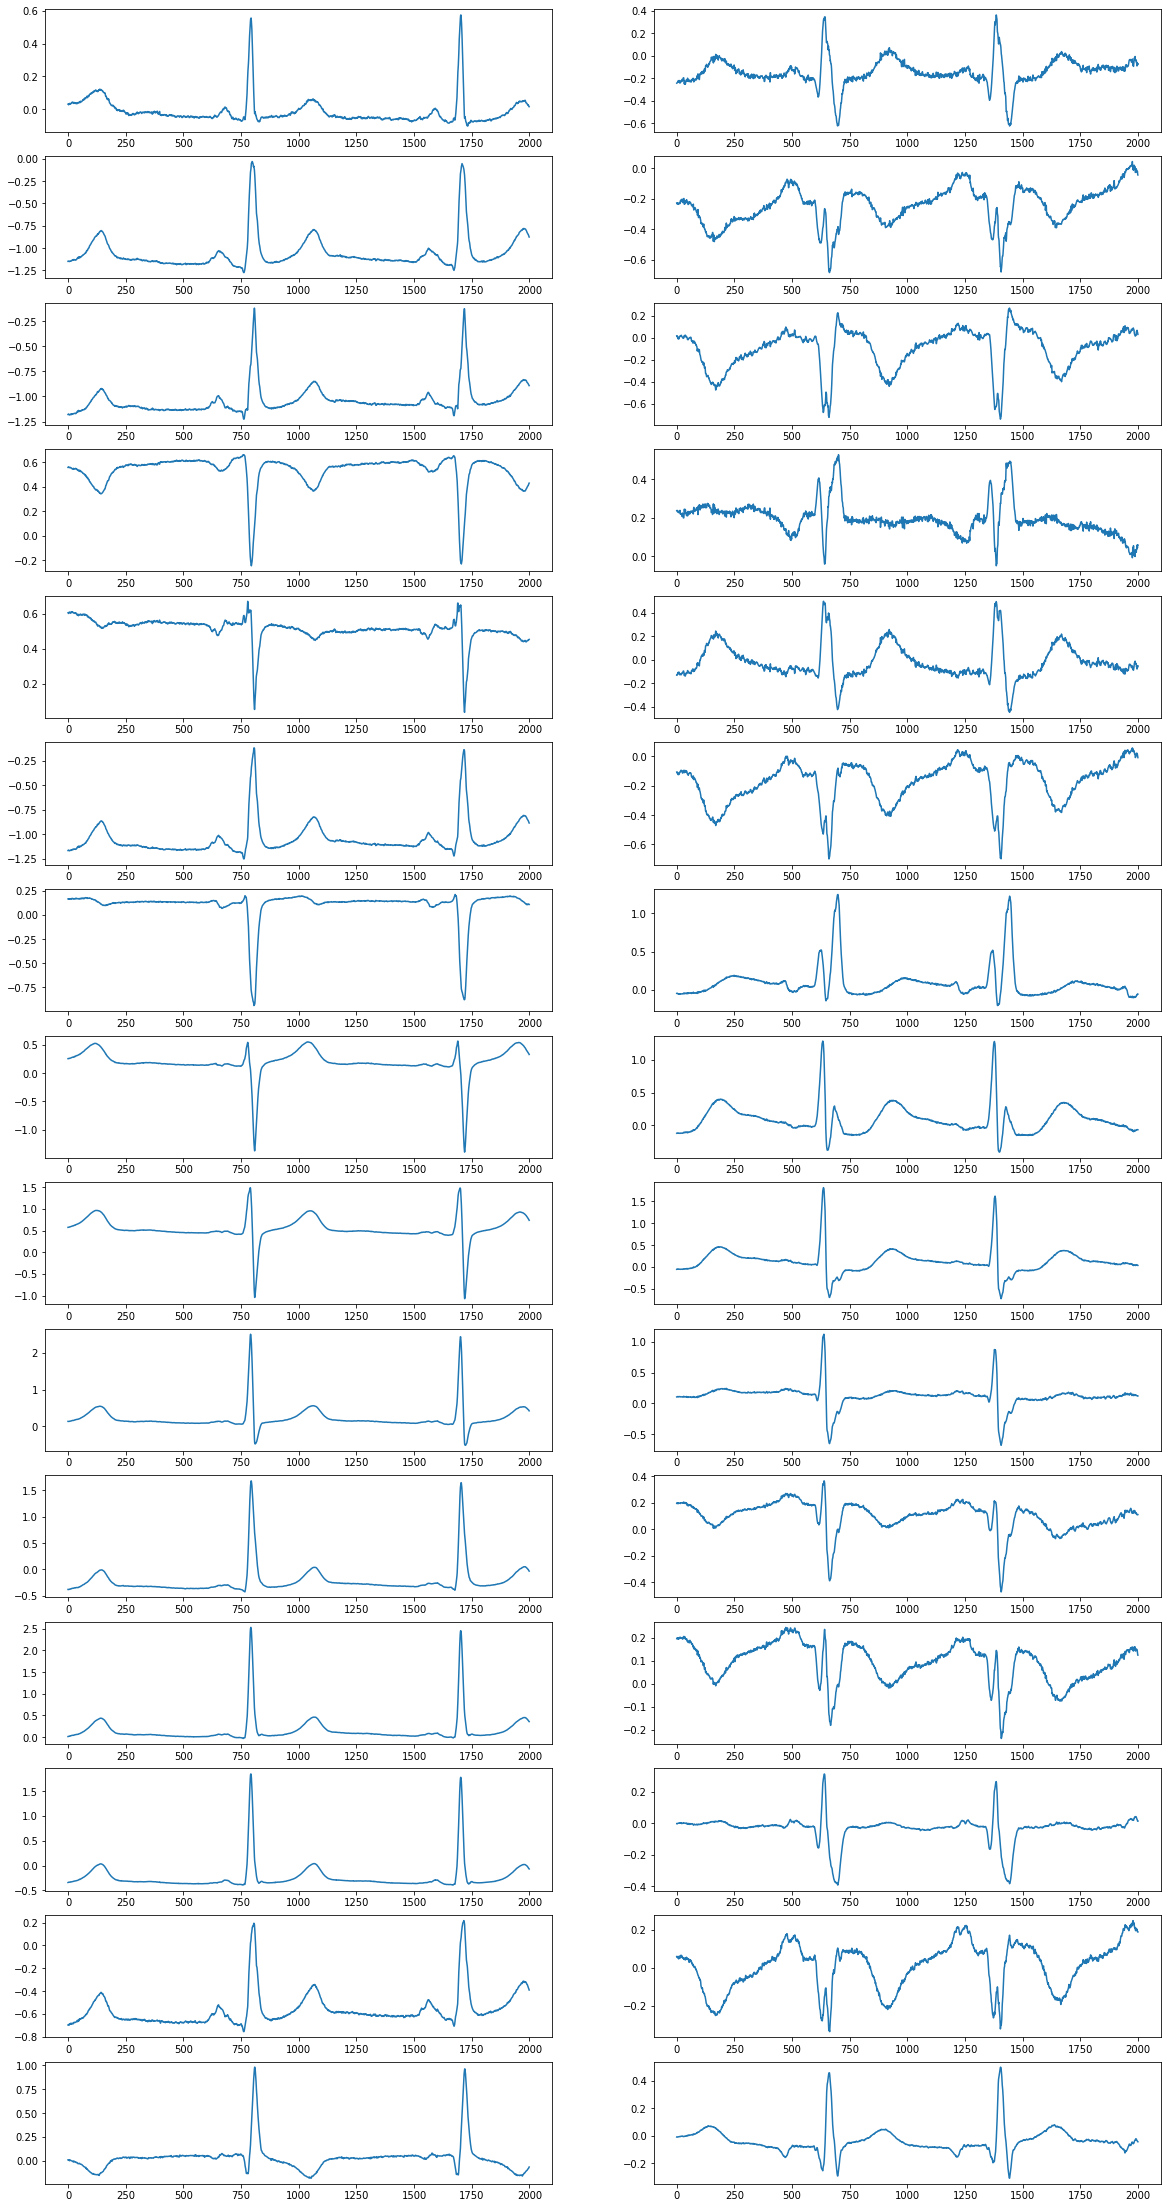

In [11]:
# Plot data 
fig, axes = plt.subplots(15, 2, figsize=(20, 40))
#fig, axes = plt.subplots(15, 5, figsize=(20, 40))
#for idx, (control_channel, infarct_channel, kardio_channel, bundle_channel, disritmia_channel) in enumerate(zip(control_data, infarct_data, kardio_data, bundle_data, disritmia_data)):
for idx, (control_channel, infarct_channel) in enumerate(zip(control_data, infarct_data)):
     
    axes[idx][0].plot(control_channel[:2000])
    axes[idx][1].plot(infarct_channel[:2000])
    #axes[idx][2].plot(kardio_channel[:4000])
    #axes[idx][3].plot(bundle_channel[:4000])
    #axes[idx][4].plot(disritmia_channel[:4000])

### Creating training and test set

Untuk melatih dan memvalidasi jaringan LSTM, kami pertama-tama membagi data yang tersedia menjadi satu set pelatihan dan uji. Subjek set tes tidak termasuk dalam set pelatihan. Karena tidak semua rekaman memiliki panjang yang sama, semua data sinyal dibagi menjadi jendela berukuran sama. Dalam hal ini ukuran jendela adalah 2048, yang cukup besar untuk selalu menyertakan 2 detak jantung. Blok kode di bawah ini menunjukkan pemisahan data dalam pelatihan dan set tes, dan pemisahan setiap sinyal dalam jendela / urutan yang lebih kecil.

Karena beberapa subjek memiliki lebih dari satu rekaman dan setiap rekaman dipisah menjadi jendela yang terpisah, kita perlu melacak siapa setiap urutan dalam set tes milik. Ini disimpan di record_list.

In [0]:
# These are the labels we'll be using. I you want to include more heart conditions, simply add them to this list.
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
# The label map will be used to do one-hot encoding with the labels.
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

test_patients = []
train_patients = []
# We will use 80% of the available subject to train the model
# The remaining 20% will be used to test the performance.
test_size = 0.2

# Randomly divide the subjects in train and test set. 
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])
    

def make_set(df_data, label_map, record_id, window_size=4000, n_channels = 15):
    """
    1. Loads the ECG data from the records specified in df_data
    2. Divide the signal data in windows of size window_size (default of 2048 which is enough to capture 3 heart beats.)
    
    
    returns:
        dataX: contains windowed ecg data (shape = n_windwows, n_channels, window_size)
        dataY: containts label for each window
        record_list: If required also returns a list specifying the record name for each window, else is empty list.

    """
    n_windows = 0
    
    for _, record in df_data.iterrows():
        n_windows+= record['signal_length']//window_size

    dataX = np.zeros((n_windows, n_channels, window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(df_data.iterrows()):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join('/content/drive/My Drive/Colab_Notebook/ptb-diagnostic-ecg-database-1.0.0', record['name'])).p_signal.transpose()
        n_rows = signal_data.shape[-1]
        n_windows = n_rows//window_size
        dataX[nth_window:nth_window+n_windows] = np.array([signal_data[:,i*window_size:(i+1)*window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows
        
        if record_id:
            record_list+= n_windows*[record['name']]
        
    return dataX, dataY, record_list
  
# Set patient as the index of the dataframe to easily extract the meta data by patient
df_patient_records = df_records.set_index('patient')
# Select the meta data of the patient we need.
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = 2048
trainX, trainY, _ = make_set(df_train_patients, label_map, False, window_size, 15)
testX, testY, record_list = make_set(df_test_patients,label_map, True, window_size, 15)

In [13]:
testX.shape

(5627, 15, 2048)

In [14]:
trainY.shape

(18932, 2)

In [15]:
testY.shape

(5627, 2)

Distribusi awal label 0 = 0, label 1= 0


<function matplotlib.pyplot.show>

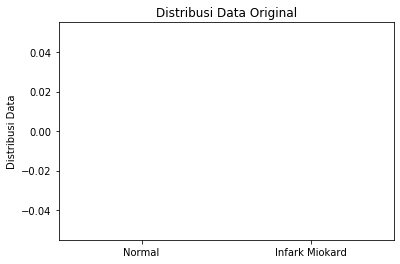

In [16]:
#normal
dist_0 = np.where(label==0)[0]

#heart disease
dist_1 = np.where(label==1)[0]

print('Distribusi awal label 0 = {0}, label 1= {1}'.format(len(dist_0),len(dist_1)))
#Plot dalam Bar-char
from matplotlib import pyplot as plt

objects = ('Normal','Infark Miokard')
Y_pos = np.arange(len(objects))
distribution = [len(dist_0), len(dist_1)]

plt.bar(Y_pos, distribution)
plt.xticks(Y_pos, objects)
plt.ylabel('Distribusi Data')
plt.title('Distribusi Data Original')
plt.show


### Building the LSTM

Jika Anda ingin mereproduksi hasil yang sama seperti yang saya dapatkan, Anda dapat mengatur seed dari generator nomor acak ke seed yang dipilih secara acak semu ini:

Kami akan menggunakan jaringan LSTM 3 lapis sederhana dengan dropout setelah setiap lapisan. Jumlah node LSTM per lapisan dimulai dengan 256 dan dibagi dua setiap lapisan berikutnya. LSTM dua lapisan pertama mengembalikan seluruh urutan output, sedangkan lapisan LSTM terakhir hanya mengembalikan langkah terakhir dari urutan outputnya, sehingga menjatuhkan dimensi temporal.

In [0]:
from keras.layers import LSTM
from keras.optimizers import Adam
import numpy
# fix random seed for reproducibility
numpy.random.seed(1337)

def make_model(input_shape, output_dim):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, batch_size=None, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    return model

### Training the network

Karena data dibagi menjadi windows, jaringan dilatih pada data berjendela, mempelajari label untuk setiap jendela / urutan. Karena ada ketidakseimbangan kelas yang besar (ada 16235 urutan infark, di mana hanya ada 3675 sekuens kontrol), mempelajari kontrol yang sehat akan menjadi lebih sulit daripada mempelajari infark. Oleh karena itu kita perlu menyesuaikan berat sampel setiap urutan dan memberikan urutan kontrol bobot yang besar.

In [0]:
# Shuffle the data
trainX, trainY = shuffle(trainX, trainY)

# Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]



In [19]:
model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1])
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=512, sample_weight=weights, verbose=1)

model dim:  (15, 2048) 2




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 18932 samples, validate on 5627 samples
Epoch 1/50





18932/18932 [==============================] - 15s 801us/step - loss: 0.1920 - acc: 0.6018 - val_loss: 0.6957 - val_acc: 0.5678
Epoch 2/50
18932/18932 [==============================] - 7s 373us/step - loss: 0.1610 - acc: 0.7410 - val_loss: 0.5063 - val_acc: 0.7944
Epoch 3/50
18932/18932 [==============================] - 7s 374us/step - loss: 0.1285 - acc: 0.8121 - val_loss: 0.4721 - val_acc: 0.8002
Epoch 4/50
18932/18932 [==============================] - 7s 368us/step - loss: 0.1081 - acc: 0.8509 - val_loss: 0.3644 - val_acc: 0.8621
Epoch 5/50
18932/18932 [==============================] - 7s 382us/step - loss: 0.0951 - acc: 0.8683 - val_loss: 0.5235 - val_acc: 0.7834
Epoch 6/50
1

In [20]:
score = model.evaluate(testX, testY, verbose=0)
print('Test cross-entropy loss: %0.2f' % score[0])
print('Test accuracy: %0.2f' % score[1])

Test cross-entropy loss: 0.78
Test accuracy: 0.86


In [21]:
score = model.evaluate(trainX, trainY, verbose=0)
print('Train cross-entropy loss: %0.2f' % score[0])
print('Train accuracy: %0.2f' % score[1])

Train cross-entropy loss: 0.02
Train accuracy: 0.99


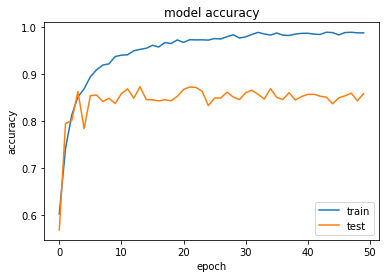

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

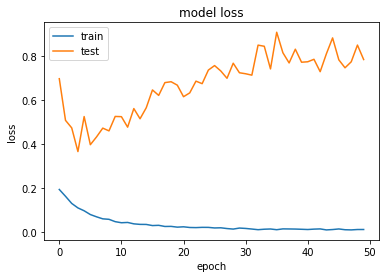

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predicting

Karena data EKG setiap mata pelajaran dibagi ke dalam urutan yang lebih kecil, pertama-tama kita perlu memprediksi label untuk setiap urutan. Segera setelah kami memiliki prediksi tersebut, kami dapat mengelompokkannya untuk setiap pasien dan melakukan prediksi tingkat pasien. Dalam hal ini kami hanya mengambil rata-rata label tingkat-urutan dan menggunakannya untuk label tingkat pasien akhir kami. Jika rata-rata 0,5 atau lebih rendah, yang berarti bahwa lebih dari setengah urutan diklasifikasikan sebagai sehat, kami mengklasifikasikan pasien sebagai sehat. Jika rata-rata lebih dari 0,5 pasien didiagnosis dengan infark miokard.

Blok kode di bawah ini menunjukkan cara melakukan prediksi, menghitung label, dan menggunakan laporan klasifikasi untuk menghitung ketepatan dan penarikan kembali.

In [24]:
#If the average is 0.5 or lower, meaning that more than half of the sequences are classified as healthy, we classify the patient as healthy. 
#If the average is more than 0.5 the patient is diagnosed with a Myocardial infarction.
Y_pred = model.predict(testX)
Y_pred=(Y_pred > 0.5)
Y_score=model.fit(trainX,trainY)

Epoch 1/1
18932/18932 [==============================] - 41s 2ms/step - loss: 0.3044 - acc: 0.8838


In [0]:
predict_rounded = Y_pred.argmax(axis=1)

In [26]:
import pandas as pd
predict_df = pd.DataFrame(predict_rounded)
predict_df

,0
0,0
1,0
2,0
3,0
4,1
...,...
5622,1
5623,1
5624,1
5625,1


In [0]:
from sklearn.metrics import confusion_matrix
cm_value= confusion_matrix(testY.argmax(axis=1),Y_pred.argmax(axis=1))
cm_value= np.array(cm_value)

In [28]:
print(cm_value)

[[1011  288]
 [ 512 3816]]


In [0]:
TP = cm_value[0][0]
FN = cm_value[1][0]
TN = cm_value[1][1]
FP = cm_value[0][1]


In [30]:
#pasien infark miokard, tes predict nya sehat
print(FN)

512


In [31]:
#patient sehat, test predict nya positif infark miokard
print(FP)

288


In [32]:
#pasien sehat
print(TN)

3816


In [33]:
#pasien infark miokard
print(TP)

1011


In [34]:
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

0.8578283277057046


In [35]:
sensitivity  = TP / (TP+FN)
print(sensitivity)

0.6638214051214708


In [36]:
precision=TP/(TP+FP)
print(precision)

0.7782909930715936


In [37]:
specificity  = TN / (TN+FP)
print(specificity)

0.9298245614035088


In [38]:
recall=TP/(TP+FN)
print(recall)

0.6638214051214708


In [39]:
F1 = 2 * (precision * recall) / (precision + recall)
print(F1)

0.7165131112686038


In [40]:
from sklearn.metrics import classification_report
report= classification_report(testY,Y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.78      0.72      1299
           1       0.93      0.88      0.91      4328

   micro avg       0.86      0.86      0.86      5627
   macro avg       0.80      0.83      0.81      5627
weighted avg       0.87      0.86      0.86      5627
 samples avg       0.86      0.86      0.86      5627



In [0]:
Y_pred = model.predict(trainX)
Y_pred=(Y_pred > 0.5)

In [0]:
predict_rounded = Y_pred.argmax(axis=1)

In [0]:
from sklearn.metrics import confusion_matrix
cm_value= confusion_matrix(trainY.argmax(axis=1),Y_pred.argmax(axis=1))
cm_value= np.array(cm_value)

In [44]:
print(cm_value)

[[ 2406   867]
 [  384 15275]]


In [0]:
TP = cm_value[0][0]
FN = cm_value[1][0]
TN = cm_value[1][1]
FP = cm_value[0][1]

In [46]:
print (TN)

15275


### Conclusion

Karena data dibagi menjadi windows, jaringan dilatih pada data berjendela, mempelajari label untuk setiap jendela / urutan. Karena ada ketidakseimbangan kelas yang besar (ada 16235 urutan infark, di mana hanya ada 3675 sekuens kontrol), mempelajari kontrol yang sehat akan menjadi lebih sulit daripada mempelajari infark. Oleh karena itu kita perlu menyesuaikan berat sampel setiap urutan dan memberikan urutan kontrol bobot yang besar.